<h1>ML_application_ECC_ENSO_v2.1</h1>
<div>by Oscar Amarilla</div>

<p>This notebook orchestrates each step of an academic project that consists of applying a machine learning algorithm to the topologycal data analysys (TDA) of the mean sea surface temperature (SST) of a region of the central tropical Pacific.</p>

<h3>Importing modules, packages and data needed for the code</h3>

In [67]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from src import config
from src.extract import sst_fields, monthly_34_sst_avg
from src.transform_and_load import TDA_process,ONI
from src.plots import *
from src.utils import *
from IPython.display import Image
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, StratifiedKFold
from sklearn.metrics import precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import StackingClassifier
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

<h2>1 - Extracting process</h2>
<p>The project needs two data, the first will be extracted from a netCDF file that contains the mean monthly SST from the period 1950-2021 from the region of interest defined by the coordinates (160ºE-270ºE,10ºN-10ºS), and the second is a csv file that contains data about the mean monthly SST of the Niño 3.4 region (170ºO-120ºO,5ºN-5ºS) of the same period of time.</p>
</br>
<p>The netCDF file containing the SST temperature can be adquired in the <a href='https://www.psl.noaa.gov/data/gridded/data.cobe.html'>Pysical Sciences Laboratory of the NOAA</a> and the data about the Niño 3.4 SST can be reached in the <a href='https://origin.cpc.ncep.noaa.gov/products/analysis_monitoring/ensostuff/detrend.nino34.ascii.txt'>Climate Prediction Center</a> of the same institution.</p>

In [2]:
sst_34 = monthly_34_sst_avg(config.INPUT_DIR,config.FILES().csv_file)

In [3]:
sst_34.tail()

,Year,Month,Anomaly (ºC)
885,2023,10,1.72
886,2023,11,2.02
887,2023,12,2.02
888,2024,1,1.82
889,2024,2,1.56


<h2>2 - Transformation and loading process</h2>
<p>The TDA_process function performs two task:</p>
<ul>
    <li>The <a href='https://poe.com/s/CVt9fTJ73PXluwaeLO97'>sub-level set filtration</a> of each SST field</li>
    <li>The computation of the <a href='https://poe.com/s/GNsohOeUu8ZlKgfr4raI'>Euler characteristic curves</a> of each filtration</li>
</ul>

In [4]:
aux = pd.read_csv("input/database.csv", index_col=0)
aux.columns = [x / 10 for x in range(180, 320)]
database = aux.loc[:,20.2:30.2].copy()
database.tail()

,20.2,20.3,20.4,20.5,20.6,20.7,20.8,20.9,21.0,21.1,...,29.3,29.4,29.5,29.6,29.7,29.8,29.9,30.0,30.1,30.2
2023_8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,2.0,3.0,1.0,-1.0,0.0,1.0,1.0,1.0,1.0
2023_9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,2.0,2.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0
2023_10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,2.0,2.0,2.0,3.0,1.0,1.0,1.0,0.0,0.0
2023_11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,3.0,-1.0
2023_12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,2.0,2.0


<hr>

<p>The ONI function takes the sst_34 dataframe and computes the <a href='https://www.climate.gov/news-features/understanding-climate/climate-variability-oceanic-ni%C3%B1o-index'>Oceanic Niño Index (ONI)</a> to then place the ouputs in the <em>enso_info</em> dataframe as a new column.</p>
<p>Specifically, the ONI function assigns a numerical label to each row of the dataframe depending on the ESNO phase that corresponds to that particular month. These labels are:</p>
<ul>
    <li>Niña: 0</li>
    <li>Normal conditions: 1</li>
    <li>Niño: 2</li>
</ul>

In [5]:
enso_info = ONI(sst_34)

enso_info.tail()

,Year,Month,Anomaly (ºC),Phase
883,2023,8,1.35,2
884,2023,9,1.60,2
885,2023,10,1.72,2
886,2023,11,2.02,2
887,2023,12,2.02,2


## 3.1 Splitting the data into test and training sets

Three approaches will be taken with respect to the inbalanced data.
- Take the data in its actual distribution and apply weights.
- Apply a ramdom undersampling.
- Apply an oversamply via SMOTE.


In [6]:
# Splitting the data into train (75%) and test, shuffled, and respecting the distribution of events.
train_X, test_X, train_Y, test_Y = train_test_split(database, enso_info['Phase'], test_size=0.25, random_state=0, shuffle=True, stratify=enso_info['Phase'])

In [7]:
# Inintializing the standarized scaler.
scaler = StandardScaler()

In [8]:
# Applying the undersamppling.
rus = RandomUnderSampler()
X_rus, Y_rus = rus.fit_resample(train_X, train_Y)

In [9]:
# Applying the oversamppling.
smote = SMOTE()
X_smote, Y_smote = smote.fit_resample(train_X, train_Y)

In [10]:
# evaluate a give model using cross-validation
def evaluate_model(models, X, y):
  # Initializing the K-fold parameter.
  cv = KFold(n_splits=10, shuffle=True, random_state=1)
  # Initializing lists to save the outputs of the training process.
  results, names = list(), list()

  # Performing CV.
  for name, model in models.items():
    scores = cross_val_score(model, X, y, scoring='precision_weighted', cv=cv, n_jobs=-1, error_score='raise')
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
  # plot model performance for comparison
  plt.figure(figsize=(10, 6))
  plt.violinplot(results, showmeans=True)
  plt.xticks(np.arange(1, len(names) + 1), names)
  plt.xlabel('Model')
  plt.ylabel('Precision (weighted)')
  plt.title('Model Performance Comparison')
  plt.show()

## 4 - Testing different models

In this stage seven models will be train over the three types of training data  (actual, oversampled, and undersampled). This models are:

- Logistic Regression
- Support Vector Machine
- XGBoost
- Simple Multi Layer Perceptron
- Emsemble Stacking (all previous models)

### 4.1 - Actual data

#### 4.1.1 - Logistic Regression

In [11]:
# Defining the model.
lr = LogisticRegression(class_weight='balanced')
# Defining the pipeline.
steps = list()
steps.append(('scaler', scaler))
steps.append(('model', lr))
lr_pipeline_1 = Pipeline(steps=steps)

#### 4.1.2 - Support Vector Machine

In [12]:
svm = SVC(class_weight='balanced')
steps = list()
steps.append(('scaler', scaler))
steps.append(('model', svm))
pipeline = Pipeline(steps=steps)
svm_pipeline_1 = Pipeline(steps=steps)

#### 4.1.3 - XGBoost

In [13]:
xgbc = xgb.XGBClassifier(objective='multi:softmax', num_class=3)
steps = list()
steps.append(('scaler', scaler))
steps.append(('model', xgbc))
pipeline = Pipeline(steps=steps)
xgbc_pipeline_1 = Pipeline(steps=steps)

#### 4.1.4 - Simple Multi Layer Perceptron

In [14]:
mlp = MLPClassifier(random_state=42, max_iter=500)
steps = list()
steps.append(('scaler', scaler))
steps.append(('model', mlp))
pipeline = Pipeline(steps=steps)
mlp_pipeline_1 = Pipeline(steps=steps)

### 4.1.5 - Stacking Ensemble

In [15]:
# get a stacking ensemble of models
def get_stacking(i:int):
	# define the base models
	level0 = list()
	level0.append(('lr', lr_pipeline_1))
	level0.append(('mlp', mlp_pipeline_1))
	level0.append(('xgb', xgbc_pipeline_1))
	level0.append(('svm', svm_pipeline_1))
	# define meta learner model
	# Array containing the meta learner models.
	meta_models = [LogisticRegression(), SVC(), xgb.XGBClassifier(objective='multi:softmax', num_class=3), MLPClassifier(random_state=42, max_iter=2000, early_stopping=True)]
	level1 = meta_models[i]
	# define the stacking ensemble
	model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
	return model

In [16]:
# get a list of models to evaluate
def get_models():
  models = dict()
  models['lr'] = lr_pipeline_1
  models['svm'] = svm_pipeline_1
  models['xgb'] = xgbc_pipeline_1
  models['mlp'] = mlp_pipeline_1
  models['lr_meta'] = get_stacking(0)
  models['svm_meta'] = get_stacking(1)
  models['xgb_meta'] = get_stacking(2)
  models['mlp_meta'] = get_stacking(3)
  return models

The following numbers represent the average precision of the cross-validation process and its standard deviation for each model. The plots are showing the distribution of the values obtained during the cross-validation process.

>lr 0.507 (0.057)
>svm 0.659 (0.057)
>xgb 0.676 (0.039)
>mlp 0.621 (0.048)
>lr_meta 0.677 (0.053)
>svm_meta 0.666 (0.047)
>xgb_meta 0.652 (0.084)
>mlp_meta 0.662 (0.042)


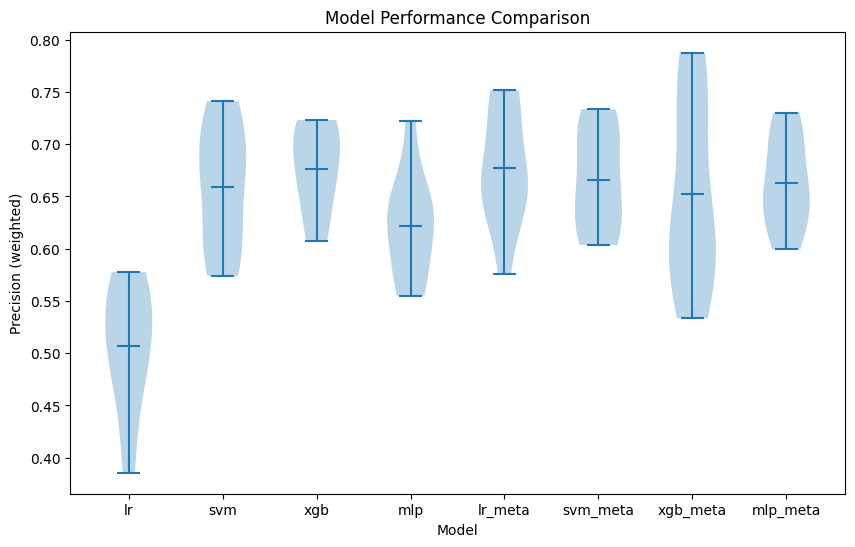

In [17]:
models = get_models()
evaluate_model(models, train_X, train_Y)

### 4.2 - Random Undersampled Data

#### 4.2.1 - Logistic Regression

In [18]:
lr = LogisticRegression()
steps = list()
steps.append(('scaler', scaler))
steps.append(('model', lr))
lr_pipeline_2 = Pipeline(steps=steps)

#### 4.2.2 - Support Vector Machine

In [19]:
svm = SVC()
steps = list()
steps.append(('scaler', scaler))
steps.append(('model', svm))
svm_pipeline_2 = Pipeline(steps=steps)

#### 4.2.3 - XGBoost

In [20]:
xgbc = xgb.XGBClassifier(objective='multi:softmax', num_class=3)
steps = list()
steps.append(('scaler', scaler))
steps.append(('model', xgbc))
xgbc_pipeline_2 = Pipeline(steps=steps)

#### 4.2.4 - Simple Multi Layer Perceptron

In [21]:
mlp = MLPClassifier(random_state=42, max_iter=500)
steps = list()
steps.append(('scaler', scaler))
steps.append(('model', mlp))
mlp_pipeline_2 = Pipeline(steps=steps)

### 4.5 - Stacking Ensemble

In [22]:
def get_stacking(i:int):
	level0 = list()
	level0.append(('lr', lr_pipeline_2))
	level0.append(('mlp', mlp_pipeline_2))
	level0.append(('xgb', xgbc_pipeline_2))
	level0.append(('svm', svm_pipeline_2))
	meta_models = [LogisticRegression(random_state=42), SVC(random_state=42), xgb.XGBClassifier(objective='multi:softmax', num_class=3), MLPClassifier(random_state=42, max_iter=2000)]
	level1 = meta_models[i]
	model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
	return model

In [23]:
def get_models():
  models = dict()
  models['lr'] = lr_pipeline_2
  models['svm'] = svm_pipeline_2
  models['xgb'] = xgbc_pipeline_2
  models['mlp'] = mlp_pipeline_2
  models['lr_meta'] = get_stacking(0)
  models['svm_meta'] = get_stacking(1)
  models['xgb_meta'] = get_stacking(2)
  models['mlp_meta'] = get_stacking(3)
  return models

>lr 0.510 (0.079)
>svm 0.618 (0.056)
>xgb 0.659 (0.037)
>mlp 0.619 (0.054)
>lr_meta 0.637 (0.068)
>svm_meta 0.623 (0.075)
>xgb_meta 0.595 (0.056)


/home/o-amarilla/TFG/tfg/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


>mlp_meta 0.618 (0.071)


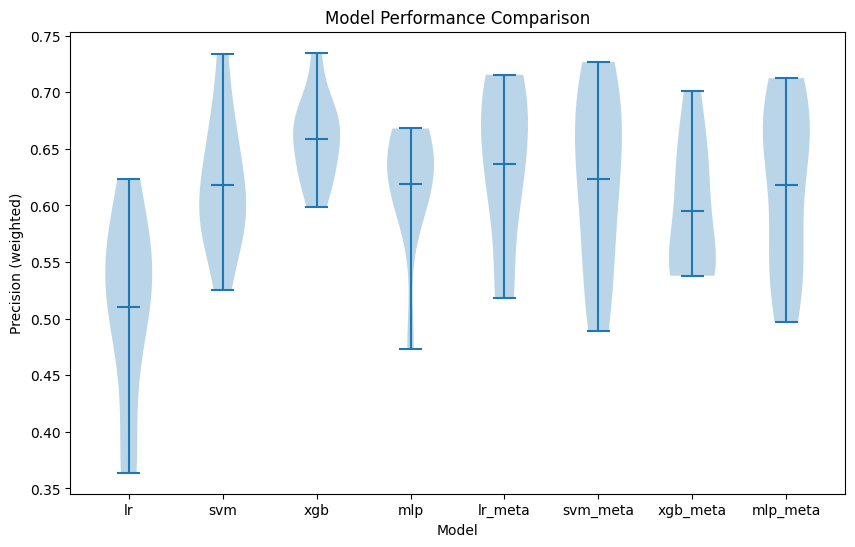

In [24]:
models = get_models()
evaluate_model(models, X_rus, Y_rus)

### 4.3 - SMOTE

#### 4.3.1 - Logistic Regression

In [25]:
lr = LogisticRegression(random_state=42, solver='newton-cg')
steps = list()
steps.append(('scaler', scaler))
steps.append(('model', lr))
lr_pipeline_3 = Pipeline(steps=steps)

#### 4.3.2 - Support Vector Machine

In [26]:
svm = SVC(random_state=42)
steps = list()
steps.append(('scaler', scaler))
steps.append(('model', svm))
svm_pipeline_3 = Pipeline(steps=steps)

#### 4.3.3 - XGBoost

In [27]:
xgbc = xgb.XGBClassifier(objective='multi:softmax', num_class=3, random_state=42)
steps = list()
steps.append(('scaler', scaler))
steps.append(('model', xgbc))
xgbc_pipeline_3 = Pipeline(steps=steps)

#### 4.3.4 - The Simple Multi Layer Perceptron Model

In [28]:
mlp = MLPClassifier(random_state=42, max_iter=1000)
steps = list()
steps.append(('scaler', scaler))
steps.append(('model', mlp))
mlp_pipeline_3 = Pipeline(steps=steps)

### 4.5 - Stacking Ensemble

In [29]:
def get_stacking(i:int):
	level0 = list()
	level0.append(('lr', lr_pipeline_3))
	level0.append(('mlp', mlp_pipeline_3))
	level0.append(('xgb', xgbc_pipeline_3))
	level0.append(('svm', svm_pipeline_3))
	meta_models = [LogisticRegression(random_state=42), SVC(random_state=42), xgb.XGBClassifier(objective='multi:softmax', num_class=3, random_state=42), MLPClassifier(random_state=42, max_iter=1000)]
	level1 = meta_models[i]
	model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
	return model

In [30]:
def get_models():
  models = dict()
  models['lr'] = lr_pipeline_3
  models['svm'] = svm_pipeline_3
  models['xgb'] = xgbc_pipeline_3
  models['mlp'] = mlp_pipeline_3
  models['lr_meta'] = get_stacking(0)
  models['svm_meta'] = get_stacking(1)
  models['xgb_meta'] = get_stacking(2)
  models['mlp_meta'] = get_stacking(3)
  return models

>lr 0.584 (0.060)
>svm 0.737 (0.054)
>xgb 0.770 (0.034)
>mlp 0.763 (0.051)
>lr_meta 0.792 (0.052)
>svm_meta 0.784 (0.059)
>xgb_meta 0.786 (0.032)
>mlp_meta 0.793 (0.054)


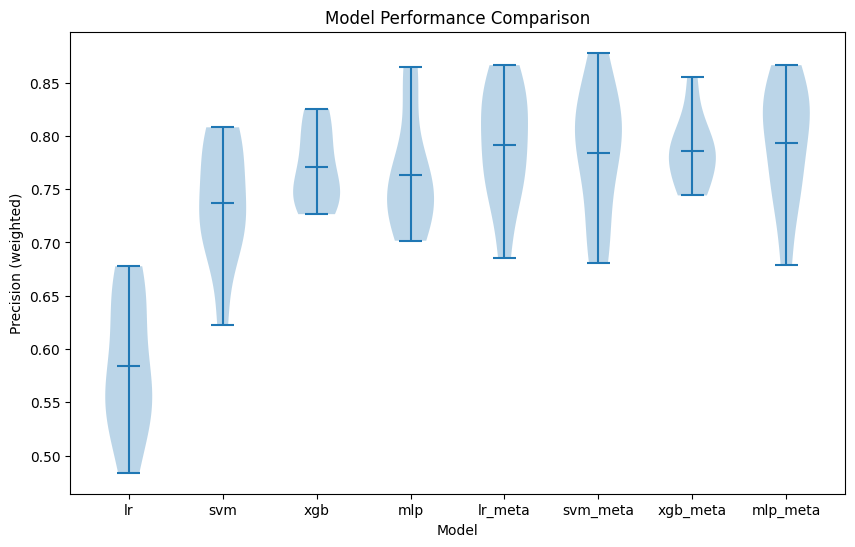

In [31]:
models = get_models()
evaluate_model(models, X_smote, Y_smote)

The following table summarize the results of the training process, taking into account the best models based on a high average precision score and a low standard deviation. 

| Data      | Best Model        | Score                    |
|-----------|-------------------|--------------------------|
| Actual    | xgb               | 0.676 ± 0.039            |
| RUS       | lr_meta           | 0.642 ± 0.049            |
| SMOTE     | mlp_meta          | 0.795 ± 0.033            |

The best results are achieved with the ensemble model with the MLPClassifier as the meta learner and applying the SMOTE technique to handle the imbalanced data.

The next step is to apply hyperparameter tunning to the individual models.

## 5 - Hyperparameter Tunning

### 5.1 - Performing the tunning

#### 5.1.1 - Logistic Regression

In [32]:
# Define the parameter grid for logistic regression
lr_param_grid = {
    'model__C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization parameter
    'model__penalty': ['l2', 'none'],  # Regularization type
    'model__solver' : ['newton-cg', 'sag', 'saga', 'lbfgs']  # Solver options
}

In [33]:
# Define the parameter grid for logistic regression
lr_param_grid_2 = {
    'model__C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization parameter
    'model__penalty':  ['elasticnet', 'l1'],  # Regularization type
    'model__solver' : ['saga']  # Solver options
}

In [34]:
lr_grid_search = GridSearchCV(lr_pipeline_3, lr_param_grid, cv=5, scoring='precision_weighted')
lr_grid_search.fit(X_smote, Y_smote)
lr_best_params = lr_grid_search.best_params_
lr_best_score = lr_grid_search.best_score_

In [35]:
print("Logistic Regression - Best Parameters:", lr_best_params)
print("Logistic Regression - Best Score:", lr_best_score)

Logistic Regression - Best Parameters: {'model__C': 100, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}
Logistic Regression - Best Score: 0.5946215593710489


In [36]:
lr_grid_search = GridSearchCV(lr_pipeline_3, lr_param_grid_2, cv=5, scoring='precision_weighted')
lr_grid_search.fit(X_smote, Y_smote)
lr_best_params = lr_grid_search.best_params_
lr_best_score = lr_grid_search.best_score_

In [37]:
print("Logistic Regression - Best Parameters:", lr_best_params)
print("Logistic Regression - Best Score:", lr_best_score)

Logistic Regression - Best Parameters: {'model__C': 1, 'model__penalty': 'l1', 'model__solver': 'saga'}
Logistic Regression - Best Score: 0.5912074473922772


#### 5.1.2 - Support Vector Machine

In [38]:
# Define the parameter grid for SVM
poly_param_grid = {
    'model__C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization parameter
    'model__kernel': ['poly'],  # Kernel type
    'model__degree':[1,2,3,4,5]
}

non_poly_param_grid = {
    'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'model__kernel' : ['rbf', 'sigmoid'],
    'model__gamma':['scale', 'auto'] + list(np.logspace(-3, 0, 4))
}

In [39]:
svm_grid_search = GridSearchCV(svm_pipeline_3, poly_param_grid, cv=5, scoring='precision_weighted')
svm_grid_search.fit(X_smote, Y_smote)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', SVC(random_state=42))]),
             param_grid={'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'model__degree': [1, 2, 3, 4, 5],
                         'model__kernel': ['poly']},
             scoring='precision_weighted')

In [40]:
svm_best_params = svm_grid_search.best_params_
svm_best_score = svm_grid_search.best_score_

In [41]:
print("SVM - Best Parameters:", svm_best_params)
print("SVM - Best Score:", svm_best_score)

SVM - Best Parameters: {'model__C': 10, 'model__degree': 5, 'model__kernel': 'poly'}
SVM - Best Score: 0.8292505907066913


In [42]:
svm_grid_search = GridSearchCV(svm_pipeline_3, non_poly_param_grid, cv=5, scoring='precision_weighted')
svm_grid_search.fit(X_smote, Y_smote)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', SVC(random_state=42))]),
             param_grid={'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'model__gamma': ['scale', 'auto', 0.001, 0.01,
                                          0.09999999999999999, 1.0],
                         'model__kernel': ['rbf', 'sigmoid']},
             scoring='precision_weighted')

In [43]:
svm_best_params = svm_grid_search.best_params_
svm_best_score = svm_grid_search.best_score_

In [44]:
print("SVM - Best Parameters:", svm_best_params)
print("SVM - Best Score:", svm_best_score)

SVM - Best Parameters: {'model__C': 10, 'model__gamma': 0.09999999999999999, 'model__kernel': 'rbf'}
SVM - Best Score: 0.8781391303662047


#### 5.1.3 - XGBoost

In [45]:
# Define the parameter grid for XGBoost
xgb_param_grid = {
    'model__max_depth': [3, 4, 5],  # Maximum depth of a tree
    'model__learning_rate': [0.01, 0.1, 0.3],  # Learning rate
    'model__n_estimators': [100, 200, 300],  # Number of trees to fit
}

In [46]:
# Create GridSearchCV objects for each model
xgb_grid_search = GridSearchCV(xgbc_pipeline_3, xgb_param_grid, cv=5, scoring='precision_weighted')
xgb_grid_search.fit(X_smote, Y_smote)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      gamma=None,
                                                      grow_policy=None,
                                                      importance_type=...
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None, num_class=3,
                                                      num_parallel_tree=None, ...))]),
             param_grid={'model__learning_rate': [0.01, 0.1, 0.3],
                         'model__max_depth': [3, 4, 5],
                         'model__n_estimators': [100, 200, 300]},
             scoring='precision_weighted')

In [47]:
xgb_best_params = xgb_grid_search.best_params_
xgb_best_score = xgb_grid_search.best_score_

In [48]:
print("XGBoost - Best Parameters:", xgb_best_params)
print("XGBoost - Best Score:", xgb_best_score)

XGBoost - Best Parameters: {'model__learning_rate': 0.1, 'model__max_depth': 4, 'model__n_estimators': 200}
XGBoost - Best Score: 0.7692075372314349


#### 5.1.4 - The Simple Multi Layer Perceptron Model

In [49]:
parameter_space = {
    'model__hidden_layer_sizes': [(10,30,10),(20,)],
    'model__activation': ['tanh', 'relu'],
    'model__solver': ['sgd', 'adam'],
    'model__alpha': [0.0001, 0.05],
    'model__learning_rate': ['constant','adaptive']
}

In [50]:
mlp = MLPClassifier(random_state=42, max_iter=3000)
steps = list()
steps.append(('scaler', scaler))
steps.append(('model', mlp))
pipeline = Pipeline(steps=steps)
grid_search = GridSearchCV(pipeline, parameter_space, scoring='precision_weighted', cv=KFold(n_splits=10, shuffle=True, random_state=1), n_jobs=-1, verbose=2)

In [51]:
grid_search.fit(X_smote, Y_smote) # X is train samples and y is the corresponding labels

Fitting 10 folds for each of 32 candidates, totalling 320 fits
[CV] END model__activation=tanh, model__alpha=0.0001, model__hidden_layer_sizes=(10, 30, 10), model__learning_rate=constant, model__solver=sgd; total time=   4.4s
[CV] END model__activation=tanh, model__alpha=0.0001, model__hidden_layer_sizes=(10, 30, 10), model__learning_rate=constant, model__solver=sgd; total time=   3.2s
[CV] END model__activation=tanh, model__alpha=0.0001, model__hidden_layer_sizes=(10, 30, 10), model__learning_rate=constant, model__solver=sgd; total time=   4.9s
[CV] END model__activation=tanh, model__alpha=0.0001, model__hidden_layer_sizes=(10, 30, 10), model__learning_rate=constant, model__solver=adam; total time=   1.8s
[CV] END model__activation=tanh, model__alpha=0.0001, model__hidden_layer_sizes=(10, 30, 10), model__learning_rate=constant, model__solver=adam; total time=   1.4s
[CV] END model__activation=tanh, model__alpha=0.0001, model__hidden_layer_sizes=(10, 30, 10), model__learning_rate=adapt

GridSearchCV(cv=KFold(n_splits=10, random_state=1, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model',
                                        MLPClassifier(max_iter=3000,
                                                      random_state=42))]),
             n_jobs=-1,
             param_grid={'model__activation': ['tanh', 'relu'],
                         'model__alpha': [0.0001, 0.05],
                         'model__hidden_layer_sizes': [(10, 30, 10), (20,)],
                         'model__learning_rate': ['constant', 'adaptive'],
                         'model__solver': ['sgd', 'adam']},
             scoring='precision_weighted', verbose=2)

In [52]:
print('Best parameters found:\n', grid_search.best_params_)
print("XGBoost - Best Score:", grid_search.best_score_)

Best parameters found:
 {'model__activation': 'relu', 'model__alpha': 0.0001, 'model__hidden_layer_sizes': (20,), 'model__learning_rate': 'constant', 'model__solver': 'adam'}
XGBoost - Best Score: 0.7542796134195503


### 5.2 Setting the Models

#### 5.2.1 - Logistic Regression

In [53]:
lr = LogisticRegression(C=100, random_state=42, penalty='l1', solver='saga')
# Defining the pipeline.
steps = list()
steps.append(('scaler', scaler))
steps.append(('model', lr))
lr_pipeline = Pipeline(steps=steps)

#### 5.2.2 - Support Vector Machine

In [66]:
svm = SVC(C=10, gamma=0.1, kernel='rbf', random_state=42)
# Defining the pipeline.
steps = list()
steps.append(('scaler', scaler))
steps.append(('model', svm))
svm_pipeline = Pipeline(steps=steps)

#### 5.2.3 - XGBoost

In [55]:
xgbc = xgb.XGBClassifier(objective='multi:softmax', num_class=3, random_state=42, learning_rate=0.1, max_depth=4, n_estimators=300)
steps = list()
steps.append(('scaler', scaler))
steps.append(('model', xgbc))
xgbc_pipeline = Pipeline(steps=steps)

#### 5.2.4 - The Simple Multi Layer Perceptron Model

In [61]:
mlp = MLPClassifier(activation='relu', alpha=0.0001, hidden_layer_sizes=(20,), learning_rate='constant', solver='adam', random_state=42, max_iter=3000)
steps = list()
steps.append(('scaler', scaler))
steps.append(('model', mlp))
mlp_pipeline = Pipeline(steps=steps)

#### 5.2.5 - Stacking Ensemble

In [62]:
# get a stacking ensemble of models
def mlp_meta():
	# define the base models
	level0 = list()
	level0.append(('lr', lr_pipeline))
	level0.append(('mlp', mlp_pipeline))
	level0.append(('xgb', xgbc_pipeline))
	level0.append(('svm', svm_pipeline))
  # meta learner.
	level1 = MLPClassifier(random_state=42)
	# define the stacking ensemble.
	model = StackingClassifier(estimators=level0, final_estimator=level1, cv=KFold(n_splits=10, shuffle=True, random_state=1))
	return model

## 6 Training the model

In [63]:
final_model = mlp_meta().fit(X_smote, Y_smote)

In [64]:
y_hat = final_model.predict(test_X)

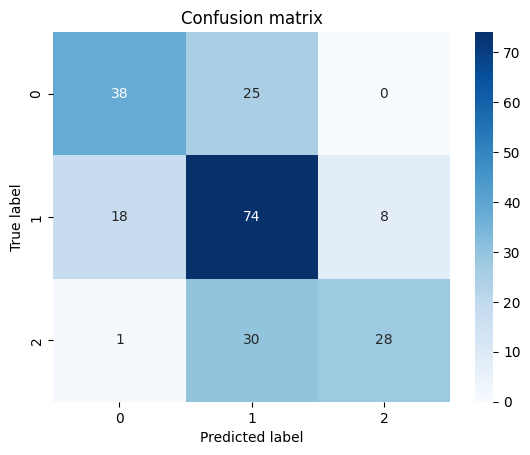

In [65]:
# Compute the confusion matrix
conf_mat = confusion_matrix(y_true=test_Y, y_pred=y_hat)

sns.heatmap(data=conf_mat, annot=True, fmt=".0f", cmap='Blues')

# Add labels and title
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix')

# Show the plot
plt.show()

In [72]:
precision = round(precision_score(test_Y, y_hat, average='weighted'),2)
print(f'The precision obtained with the final model is {precision}')

The precision obtained with the final model is 0.65
